# Final feature set

## Set-up

In [1]:
import os
import getpass
import pickle

import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from s3fs import S3FileSystem
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 3
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [6]:
AWS_ACCESS_KEY_ID = getpass.getpass()
AWS_SECRET_KEY = getpass.getpass()

 ····················
 ········································


In [7]:
s3_filesystem = S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_KEY
)

## 1. Load results of PFI feature selection

In [8]:
with open('data/processed/pfi_feature_selection_results.pickle', 'rb') as file:  
    pfi_feature_selection_df = pickle.load(file)

In [9]:
pfi_feature_selection_df.head()

,features,model,dev_error,features_to_drop
ROUND_1,"[gw, Aerial Duels - Won - Percentage, Aerial D...",<keras.engine.training.Model object at 0x7f838...,3.45935,"[Passes Received - Opponents Half (Left), Chan..."
ROUND_2,"[Passing - Through Balls, Crosses - Opponents ...",<keras.engine.training.Model object at 0x7f838...,3.49641,"[Passes - Successful - Own Half, Passes - Oppo..."
ROUND_3,"[Tackles Lost, Passing - Through Balls, Premie...",<keras.engine.training.Model object at 0x7f836...,3.48102,"[Tackles Won - Possession, Duels Won, Premier ..."
ROUND_4,"[Passing - Through Balls, Chances Created (Cen...",<keras.engine.training.Model object at 0x7f836...,3.48853,"[Big Chances Total, Launches, Tricks, Saves - ..."
ROUND_5,"[Passing - Through Balls, Chances Created (Cen...",<keras.engine.training.Model object at 0x7f836...,3.47849,"[Goals From Set Plays, Passes - Opponents Half..."


In [10]:
pfi_feature_selection_df['num_features'] = pfi_feature_selection_df['features'].apply(len)
pfi_feature_selection_df['num_features_dropped'] = pfi_feature_selection_df['features_to_drop'].apply(len)

In [11]:
pfi_feature_selection_df

,features,model,dev_error,features_to_drop,num_features,num_features_dropped
ROUND_1,"[gw, Aerial Duels - Won - Percentage, Aerial D...",<keras.engine.training.Model object at 0x7f838...,3.45935,"[Passes Received - Opponents Half (Left), Chan...",279,28
ROUND_2,"[Passing - Through Balls, Crosses - Opponents ...",<keras.engine.training.Model object at 0x7f838...,3.49641,"[Passes - Successful - Own Half, Passes - Oppo...",251,25
ROUND_3,"[Tackles Lost, Passing - Through Balls, Premie...",<keras.engine.training.Model object at 0x7f836...,3.48102,"[Tackles Won - Possession, Duels Won, Premier ...",226,23
ROUND_4,"[Passing - Through Balls, Chances Created (Cen...",<keras.engine.training.Model object at 0x7f836...,3.48853,"[Big Chances Total, Launches, Tricks, Saves - ...",203,21
ROUND_5,"[Passing - Through Balls, Chances Created (Cen...",<keras.engine.training.Model object at 0x7f836...,3.47849,"[Goals From Set Plays, Passes - Opponents Half...",182,19
ROUND_6,"[Passing - Through Balls, Chances Created (Cen...",<keras.engine.training.Model object at 0x7f836...,3.46516,"[Shots Off Target, Solo Goals, Own Goals, Save...",163,17
ROUND_7,"[Passing - Through Balls, Chances Created (Cen...",<keras.engine.training.Model object at 0x7f836...,3.46761,"[Goal Conversion, Blocks, Launches - Unsuccess...",146,15
ROUND_8,"[Passing - Through Balls, Chances Created (Cen...",<keras.engine.training.Model object at 0x7f836...,3.48328,"[Crosses - Successful, Minutes Per Shot On Tar...",131,13
ROUND_9,"[Chances Created (Centre Zone), xG Freekick, C...",<keras.engine.training.Model object at 0x7f836...,3.49303,"[Key Contributions, Aerial Duels Total, Sky Mi...",118,12
ROUND_10,"[Recoveries, Big Chances Scored, Chances Creat...",<keras.engine.training.Model object at 0x7f836...,3.48915,"[Take Ons - Failed, Passes - Unsuccessful, Hit...",106,11


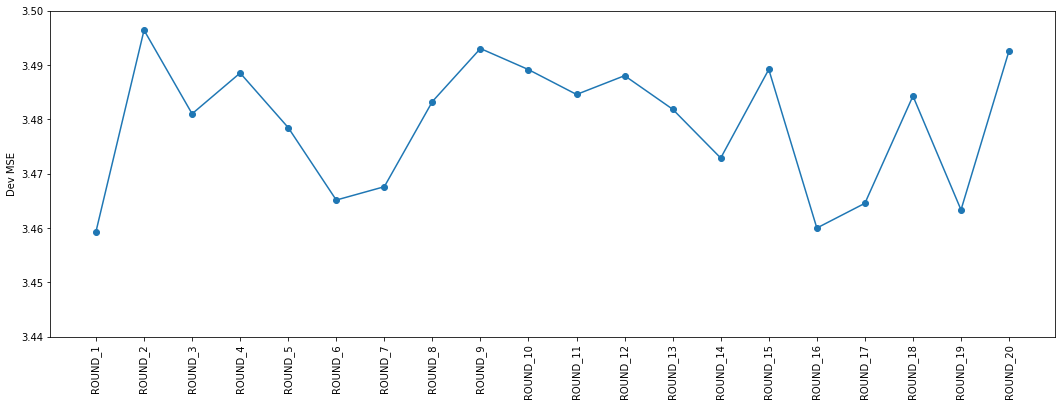

In [12]:
plt.figure(figsize=(18, 6))
plt.plot(pfi_feature_selection_df.index, pfi_feature_selection_df['dev_error'], '-o')
plt.xticks(rotation=90)
plt.ylim(3.44, 3.5)
plt.ylabel('Dev MSE')
plt.show()

Whilst using the full feature set gives the best dev MSE, 279 features will require too much maintenance. Rounds 16 and 19 give a similar level of performance with less than a fifth of the features. 

In [13]:
# Difference in features between round 16 and 19
set(pfi_feature_selection_df.loc['ROUND_16']['features']) - set(pfi_feature_selection_df.loc['ROUND_19']['features'])

{'Chances Created (Right Zone)',
 'Clean Sheets',
 'Distribution - Successful',
 'Distribution - Unsuccessful',
 'Dribbles - Successful Percentage',
 'Handballs',
 'Passes - Opponents Half - Centre - Unsuccessful',
 'Premier League Total Red Cards',
 'Sky Bonus Shots Tier 1',
 'Take Ons - Successful Percentage',
 'Touches - Opponents Half - Right',
 'double_gameweek',
 'gw',
 'next_gameweek_number_of_promoted_side_opponent',
 'number_of_top_6_last_season_opponent',
 'xGI Expected Goal Involvement'}

We will use ROUND 16 features going forward given some features are definitely desirable like 'Clean Sheets' and 'next_gameweek_number_of_promoted_side_opponent'

Round 16 features

In [14]:
set(pfi_feature_selection_df.loc['ROUND_16']['features'])

{'Aerial Duels - Won - Percentage',
 'Big Chances Created',
 'Caught Offside',
 'Chances Created (Right Zone)',
 'Chances From Counter Attack',
 'Clean Sheets',
 'Crosses - Open Play - Successful',
 'Crosses - Unsuccessful',
 'Distribution - Successful',
 'Distribution - Unsuccessful',
 'Dribbles - Successful Percentage',
 'Goal Kicks',
 'Goals From Penalties',
 'Ground Duels Lost',
 'Handballs',
 'ICT Influence',
 'Minutes Per Save',
 'Minutes Per Touch',
 'Pass Completion',
 'Pass Completion - Final Third',
 'Pass Completion - Opponents Half',
 'Passes - Final Third - Unsuccessful',
 'Passes - Forward - Successful',
 'Passes - Opponents Half - Centre - Unsuccessful',
 'Premier League Straight Red Cards',
 'Premier League Total Red Cards',
 'Recoveries',
 'Shots - Inside Box',
 'Shots - Long - Attempts',
 'Sky Bonus Shots Tier 1',
 'Subbed Off',
 'Subbed On',
 'Tackles - Won - Percentage',
 'Take Ons',
 'Take Ons - Successful Percentage',
 'Time Played',
 'Touches - Opponents Half - R

_What is 'Sky Bonus Shots Tier 1'?_

Features which were dropped before this round:

In [15]:
set(pfi_feature_selection_df.loc['ROUND_1']['features']) - set(pfi_feature_selection_df.loc['ROUND_16']['features'])

{'Aerial Duels Lost',
 'Aerial Duels Total',
 'Aerial Duels Won',
 'Assists',
 'Attempts From Crossed Corners',
 'Attempts From Direct Free-kick',
 'Attempts From Indirect Free-kick',
 'Attempts From Set Plays',
 'Attempts from Throw-in',
 'Bad Touches',
 'Big Chances Missed',
 'Big Chances Missed Ball',
 'Big Chances Missed Shots',
 'Big Chances Scored',
 'Big Chances Total',
 'Blocks',
 'CBI',
 'Chances Created',
 'Chances Created (Centre Zone)',
 'Chances Created (Left Zone)',
 'Chances From Open Play',
 'Chances Missed',
 'Clearances',
 'Clearances - Successful',
 'Clearances - Unsuccessful',
 'Corner Conversion',
 'Corners',
 'Corners - Successful',
 'Corners - Unsuccessful',
 'Cross Completion',
 'Crosses',
 'Crosses - Open Play - Unsuccessful',
 'Crosses - Opponents Half (Left Zone)',
 'Crosses - Opponents Half (Right Zone)',
 'Crosses - Successful',
 'Crosses From Open Play',
 'Dispossessed',
 'Distribution - Kicks From Hands',
 'Distribution - Throws',
 'Dribbles',
 'Dribbles 

Based on 'domain' knowledge we will add the following features:
- Assists
- Goals
- Goals Conceded
- Saves (to ensure GK predictions are good)

In [16]:
FEATURES_TO_ADD = ['Assists', 'Goals', 'Goals Conceded', 'Saves']

## 2. Preprocessing

### Load FFS data

In [17]:
ffs_all_data_1719 = pq.read_table(
    f"s3://fantasy-football-scout/processed/fantasy_football_scout_all_features_1718_to_1819.parquet", 
    filesystem=s3_filesystem
).to_pandas()

print(ffs_all_data_1719.shape)
ffs_all_data_1719.head()

(20449, 308)


,Name,Team,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,position,full_name,season,gw,Attempts From Set Plays Conceded,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Conceded,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Conceded (Centre Zone),Chances Conceded (Left Zone),Chances Conceded (Right Zone),Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Percentage Centre Zone),Chances Created (Percentage Left Zone),Chances Created (Percentage Right Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Percentage Left Zone),Crosses - Opponents Half (Percentage Right Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses Conceded (Left Zone),Crosses Conceded (Right Zone),Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Games Played,Goal Attempts,Goal Attempts Conceded,Goal Attempts In Box Conceded,Goal Attempts Outside Box Conceded,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goal Attempts Conceded,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Big Chance,Minutes Per Big Chance Conceded,Minutes Per Block,Minutes Per Chance,Minutes Per Chance Conceded,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xG Conceded,Minutes Per xG On Target Conceded,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Open Play Goal Attempts,Open Play Goal Attempts Conceded,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - 

In [18]:
ffs_all_data_1719.drop(columns=['Name', 'full_name'], inplace=True)

### Deal with nulls and inf values

In [19]:
columns_with_inf = []
for col in ffs_all_data_1719.columns:
    if np.inf in ffs_all_data_1719[col].values:
        print(col)
        print(ffs_all_data_1719[ffs_all_data_1719['Minutes Per xA'] == np.inf].shape[0] / ffs_all_data_1719.shape[0])
        columns_with_inf.append(col)
        print('\n')

Minutes Per xA
0.30275319086507896


Minutes Per xG
0.30275319086507896


Minutes Per xGI
0.30275319086507896


Minutes Per xGP
0.30275319086507896


Sky Minutes Per Bonus
0.30275319086507896




Looks like `inf` caused by divide by zero error. For now let's impute with 0 but if these features are shown to be predictive then may need to revisit this. Could use a very large number instead.

In [20]:
for col in columns_with_inf:
    ffs_all_data_1719[col].replace({np.inf: 0}, inplace=True)

nan

In [21]:
ffs_all_data_1719.replace({'nan': np.nan}, inplace=True)

### Drop features with all nulls

In [22]:
ffs_all_data_1719.dropna(axis=1, how='all', inplace=True)

### Add 0 minute events back into data

FFS data only includes players who played > 0 minutes. Therefore if a player is benched one gameweek then they wouldn't appear in the data although we would like to train our model on these cases.

We therefore create a 'master' DataFrame of all unique names and all possible season and gameweek combinations. We then left join the FFS data and fill in nulls with zeros.

In [23]:
ffs_all_data_1719['season'].unique()

array(['2017-2018', '2018-2019'], dtype=object)

In [24]:
ffs_data_names = ffs_all_data_1719[['name', 'Team', 'position']].drop_duplicates()
ffs_data_names['key'] = 1
ffs_data_names.shape

(721, 4)

In [25]:
seasons_df = pd.DataFrame({'season': ['2017-2018', '2018-2019']})
seasons_df['key'] = 1
seasons_df

,season,key
0,2017-2018,1
1,2018-2019,1


In [26]:
gw_df = pd.DataFrame({'gw': range(1, 39)})
gw_df['key'] = 1
gw_df.head()

,gw,key
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [27]:
all_season_gw_df = seasons_df.merge(gw_df, on='key')

In [28]:
all_season_gw_df.head()

,season,key,gw
0,2017-2018,1,1
1,2017-2018,1,2
2,2017-2018,1,3
3,2017-2018,1,4
4,2017-2018,1,5


In [29]:
all_player_season_gw_df = all_season_gw_df.merge(ffs_data_names, on='key')
all_player_season_gw_df.drop('key', axis=1, inplace=True)
all_player_season_gw_df.shape

(54796, 5)

In [30]:
all_player_season_gw_df.head()

,season,gw,name,Team,position
0,2017-2018,1,gabriel_fernando de jesus,MCI,FWD
1,2017-2018,1,danny_welbeck,ARS,FWD
2,2017-2018,1,sam_vokes,BUR,FWD
3,2017-2018,1,jamie_vardy,LEI,FWD
4,2017-2018,1,diafra_sakho,WHU,FWD


In [31]:
ffs_data = all_player_season_gw_df.merge(ffs_all_data_1719, on=['name', 'Team', 'position', 'gw', 'season'], how='left')
print(ffs_data.shape)
ffs_data.head()

(54796, 278)


,season,gw,name,Team,position,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penal

In [32]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)
ffs_data.head()

,season,gw,name,Team,position,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penal

In [33]:
ffs_data.isnull().sum()

season                                   0
gw                                       0
name                                     0
Team                                     0
position                                 0
                                     ...  
xG Prevented                         34347
xG Set Play                          34347
xGI Delta (Goals + Assists - xGI)    34347
xGI Expected Goal Involvement        34347
total_points                         34347
Length: 278, dtype: int64

In [34]:
# From an offline check the missing entries are 0 minutes players in a given GW. We can therefore fill all missing data points with 0.
ffs_data.fillna(0, inplace=True)

### Position dummies

In [35]:
ffs_data = pd.get_dummies(ffs_data, columns=['position'])

In [36]:
ffs_data.rename(columns={'Team': 'team_name'}, inplace=True)

### Merge fixture and odds data

Merging fixture data also serves another purpose. In the previous step we created _all_ possible gameweek-player combinations. However, due to double gameweeks there are many cases where a player simply would not feature in a given gameweek and in this case we want to remove that player-gameweek for the data. An inner join to fixtures data does this.

In [37]:
fixture_and_odds_features = pd.read_parquet('data/processed/formatted_fixture_and_odds_features_2016_to_2019.parquet')
print(fixture_and_odds_features.shape)
fixture_and_odds_features.head()

(2193, 19)


,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2016-17,1,Arsenal,2.34,1.73,1.72,1.0,0,0,0,1,0,2.51,1.58,1.79,0.0,0.0,1.0,0.0
1,2016-17,2,Arsenal,2.51,1.58,1.79,0.0,0,1,0,1,0,3.00,0.64,4.82,0.0,0.0,0.0,0.0
2,2016-17,3,Arsenal,3.00,0.64,4.82,0.0,0,0,0,1,0,3.00,0.61,5.18,1.0,0.0,1.0,0.0
3,2016-17,4,Arsenal,3.00,0.61,5.18,1.0,0,1,0,1,0,3.08,0.62,4.99,0.0,1.0,0.0,0.0
4,2016-17,5,Arsenal,3.08,0.62,4.99,0.0,1,0,0,1,0,2.43,1.42,2.07,1.0,0.0,0.0,0.0


### Format FFS team names and seasons to match

In [38]:
ffs_data.head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [39]:
ffs_data['season'].replace({'2017-2018': '2017-18', '2018-2019': '2018-19'}, inplace=True)

In [40]:
ffs_team_name_to_fpl = {
    'WHU': 'West Ham United', 
    'BUR': 'Burnley', 
    'HUD': 'Huddersfield Town', 
    'ARS': 'Arsenal', 
    'CRY': 'Crystal Palace', 
    'WAT': 'Watford', 
    'FUL': 'Fulham', 
    'LIV': 'Liverpool', 
    'BOU': 'Bournemouth',
    'WOL': 'Wolverhampton Wanderers', 
    'EVE': 'Everton', 
    'LEI': 'Leicester City', 
    'WBA': 'West Bromwich Albion', 
    'NEW': 'Newcastle United', 
    'SOU': 'Southampton', 
    'MUN': 'Manchester United', 
    'SWA': 'Swansea City', 
    'BHA': 'Brighton & Hove Albion',
    'CHE': 'Chelsea',
    'CAR': 'Cardiff City',
    'MCI': 'Manchester City',
    'TOT': 'Tottenham Hotspur',
    'STK': 'Stoke City'
}

In [41]:
ffs_data['team_name'].replace(ffs_team_name_to_fpl, inplace=True)

In [42]:
ffs_data.head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [43]:
ffs_data.shape

(54796, 281)

### Combine feature and odds features

In [44]:
fixture_and_odds_features.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2016-17,1,Arsenal,2.34,1.73,1.72,1.0,0,0,0,1,0,2.51,1.58,1.79,0.0,0.0,1.0,0.0
1,2016-17,2,Arsenal,2.51,1.58,1.79,0.0,0,1,0,1,0,3.00,0.64,4.82,0.0,0.0,0.0,0.0
2,2016-17,3,Arsenal,3.00,0.64,4.82,0.0,0,0,0,1,0,3.00,0.61,5.18,1.0,0.0,1.0,0.0
3,2016-17,4,Arsenal,3.00,0.61,5.18,1.0,0,1,0,1,0,3.08,0.62,4.99,0.0,1.0,0.0,0.0
4,2016-17,5,Arsenal,3.08,0.62,4.99,0.0,1,0,0,1,0,2.43,1.42,2.07,1.0,0.0,0.0,0.0


In [45]:
ffs_data.head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [46]:
# Inner join also removes gw-season fixtures which did not happen but were filled with 0s
print(ffs_data.shape)

ffs_data = ffs_data.merge(
    fixture_and_odds_features, 
    on=['season', 'gw', 'team_name'], 
    how='inner'
)

print(ffs_data.shape)

ffs_data.head()

(54796, 281)
(46926, 297)


,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

### Drop certain features

In [47]:
FEATURES_TO_DROP = [
    'Overall Points',
    'Starts',
    'Appearances',
    'BPS Baseline',
    'BPS CBI',
    'BPS Clean Sheets',
    'BPS Goals',
    'BPS Pass Completion',
    'BPS Recoveries',
    'BPS Time Played',
    'BPS Yellow Cards',
    'Minutes Per Baseline BPS',
    'Exact Time Played',
    'Ownership',
    'Bonus Points'
]

In [48]:
ffs_data.drop(columns=FEATURES_TO_DROP, inplace=True)

## 3. Create target and train/dev/test splits

### Create target

In [49]:
ffs_data['total_points_plus1_gw'] = ffs_data.groupby(['name'])['total_points'].shift(-1)
ffs_data = ffs_data[~ffs_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

In [50]:
ffs_data.head()

,season,gw,name,team_name,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Own Goals,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties Missed,Premier League Straight Red Cards,Premier League Total Red Cards,Premier League Yellow Cards,Recoveries,Saves,Saves (Shots Inside Box),Saves (Shots Outside Box),Saves - Caught,Saves - Claims,Saves - Di

In [51]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)

## 4. Explore final feature set

In [52]:
FINAL_FEATURES = pfi_feature_selection_df.loc['ROUND_16']['features'].copy()
FINAL_FEATURES += FEATURES_TO_ADD
len(FINAL_FEATURES)

59

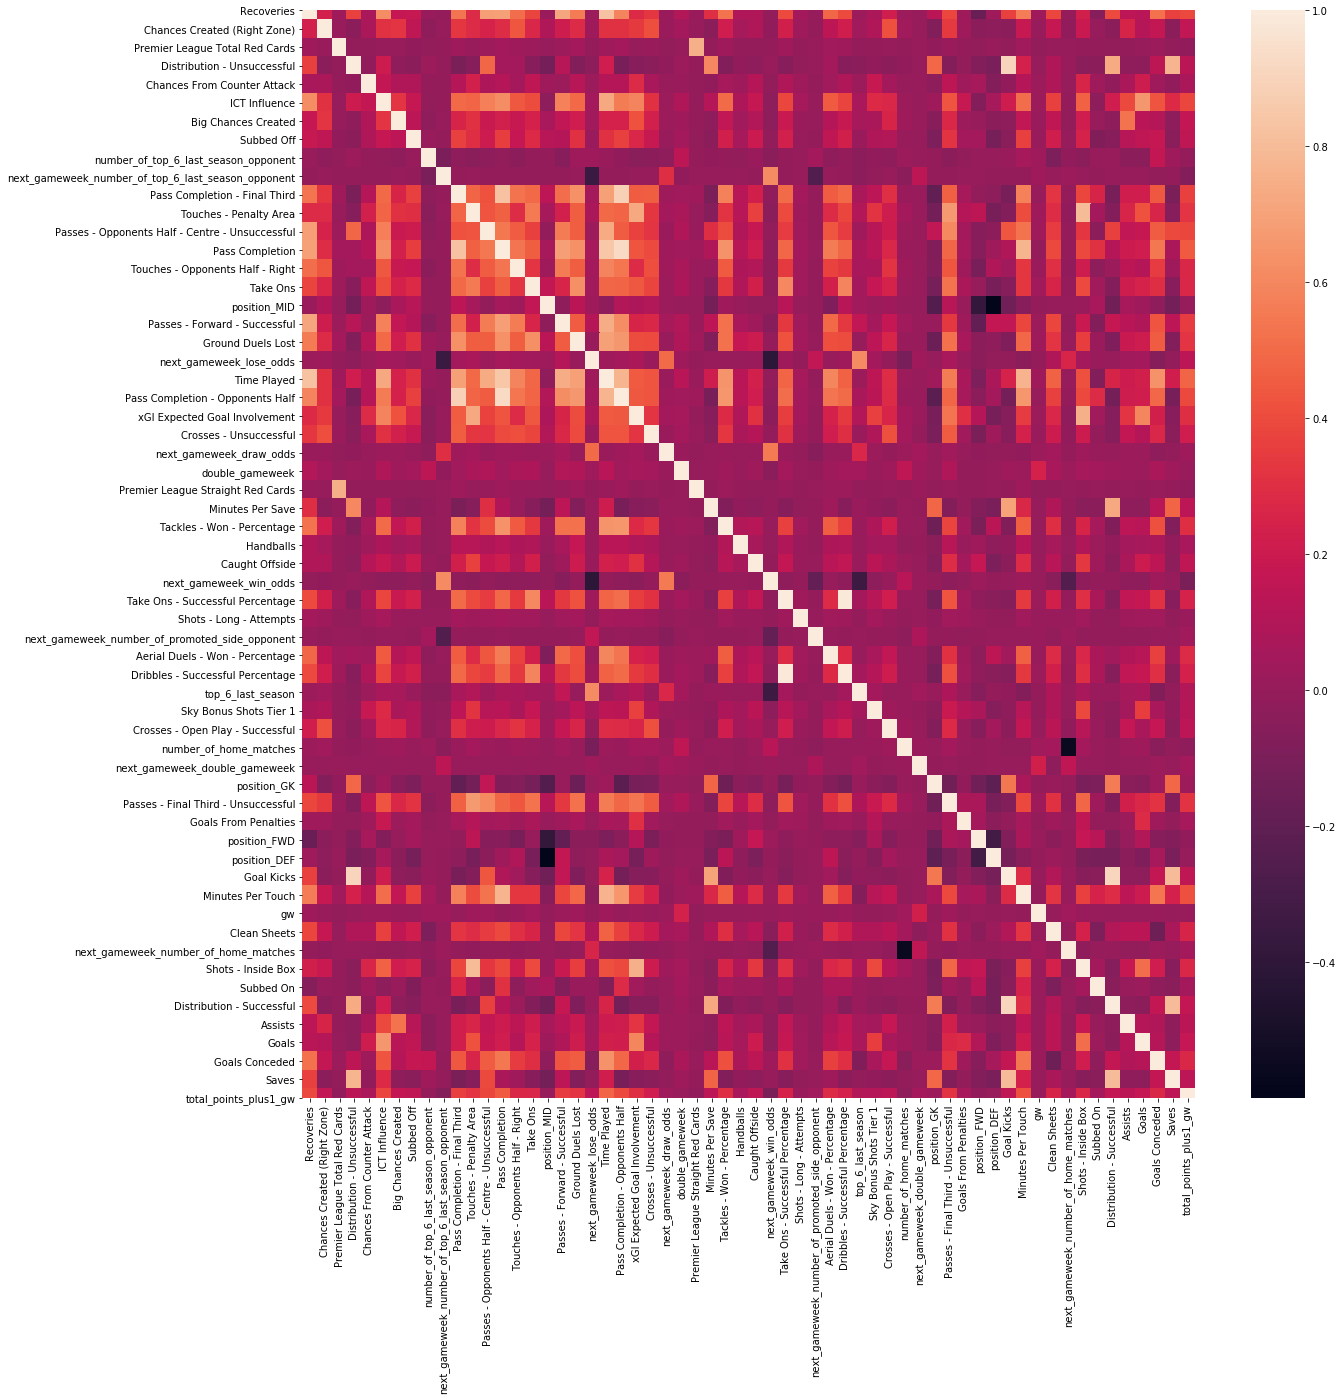

In [53]:
plt.figure(figsize=(20, 20))
sns.heatmap(ffs_data[FINAL_FEATURES + ['total_points_plus1_gw']].corr())
plt.show()

In [54]:
ffs_data[FINAL_FEATURES + ['total_points_plus1_gw']].corr()['total_points_plus1_gw'].sort_values(ascending=False)

total_points_plus1_gw                                 1.000000
Time Played                                           0.478726
Pass Completion                                       0.449425
Minutes Per Touch                                     0.413653
Pass Completion - Opponents Half                      0.393843
Recoveries                                            0.391472
ICT Influence                                         0.386456
Passes - Opponents Half - Centre - Unsuccessful       0.382983
Pass Completion - Final Third                         0.363981
Passes - Forward - Successful                         0.343881
Ground Duels Lost                                     0.322912
Touches - Penalty Area                                0.319519
Passes - Final Third - Unsuccessful                   0.316624
Tackles - Won - Percentage                            0.295876
xGI Expected Goal Involvement                         0.295694
Aerial Duels - Won - Percentage                       0

`Sky Bonus Shots Tier 1` is a scalar of `Shots on Target` (see https://www.fantasyfootballscout.co.uk/2019/08/01/the-changes-to-bonus-points-in-sky-sports-fantasy-football-this-season/)

In [55]:
np.corrcoef(ffs_data['Shots On Target'], ffs_data['Sky Bonus Shots Tier 1'])

array([[1.       , 0.5462603],
       [0.5462603, 1.       ]])

In [56]:
np.corrcoef(ffs_data['Shots'], ffs_data['Sky Bonus Shots Tier 1'])

array([[1.        , 0.39457588],
       [0.39457588, 1.        ]])

To avoid dependency on Sky's transformation of the 'Shots on Target' statistic, which may change in the future, we replace this with `Shots on Target`. As can be seen above this is highly correlated so should be a good proxy.

In [57]:
FINAL_FEATURES.remove('Sky Bonus Shots Tier 1')

In [58]:
FINAL_FEATURES.append('Shots On Target')

In [60]:
print(len(FINAL_FEATURES))
set(FINAL_FEATURES)

59


{'Aerial Duels - Won - Percentage',
 'Assists',
 'Big Chances Created',
 'Caught Offside',
 'Chances Created (Right Zone)',
 'Chances From Counter Attack',
 'Clean Sheets',
 'Crosses - Open Play - Successful',
 'Crosses - Unsuccessful',
 'Distribution - Successful',
 'Distribution - Unsuccessful',
 'Dribbles - Successful Percentage',
 'Goal Kicks',
 'Goals',
 'Goals Conceded',
 'Goals From Penalties',
 'Ground Duels Lost',
 'Handballs',
 'ICT Influence',
 'Minutes Per Save',
 'Minutes Per Touch',
 'Pass Completion',
 'Pass Completion - Final Third',
 'Pass Completion - Opponents Half',
 'Passes - Final Third - Unsuccessful',
 'Passes - Forward - Successful',
 'Passes - Opponents Half - Centre - Unsuccessful',
 'Premier League Straight Red Cards',
 'Premier League Total Red Cards',
 'Recoveries',
 'Saves',
 'Shots - Inside Box',
 'Shots - Long - Attempts',
 'Shots On Target',
 'Subbed Off',
 'Subbed On',
 'Tackles - Won - Percentage',
 'Take Ons',
 'Take Ons - Successful Percentage',
 '

In [71]:
# Feature with uppercase characters are from football scout. Determines number of tables which need to be scraped.
len([feat for feat in FINAL_FEATURES if any(x.isupper() for x in feat)])

47